![title](/home/francescocremonesiext/new-areas/imaging-directions.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import nibabel as nib
from skimage.morphology import binary_dilation, binary_erosion, label
import os
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List, Dict
from functools import reduce
from tqdm import tqdm
import logging
import pickle

In [3]:
from library import define_area_by_specs_with_heuristics, totalseg_tasks
from lymph_node_levels_specs import level_specs

In [4]:

logFormatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
rootLogger = logging.getLogger('root') 

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
consoleHandler.setLevel(logging.DEBUG)
rootLogger.addHandler(consoleHandler)

## Generic functions

This section defines the functions needed for rule-based segmentation of aires ganglionnaires.

In [5]:
path_to_totalseg_segmentations = '/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/cal_cancer_patients/seg_and_metrics_run_2024_04_09/output/SEG'
path_to_ct = '/mnt/lvssd/common/AI4PET/data_v1.0.0/data/02_intermediate/CAL/CT'
totalseg_structure_to_task = {struct: task for task in totalseg_tasks for struct in os.listdir(os.path.join(path_to_totalseg_segmentations, task, '0000002_20171205'))}
output_dir = '/tmp'

In [6]:
#path_to_totalseg_segmentations = '/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/autopet_control_patients/seg_and_metrics_run_2024_11_22/output/SEG'
#path_to_ct = '/mnt/nas/autoPET/data/FDG-PET-CT-Lesions_nifti_neg'
#totalseg_structure_to_task = {struct: task for task in totalseg_tasks for struct in os.listdir(os.path.join(path_to_totalseg_segmentations, task, 'PETCT_1bdefef7d5_20060114'))}
#totalseg_structures = list(totalseg_structure_to_task.keys())

## Process one patient

In [7]:
only_bounding_boxes = True

In [8]:
patient_list = os.listdir(path_to_totalseg_segmentations + '/total')

In [9]:
patient = patient_list[0]

In [10]:
level_specs['level_iii_left']

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [11]:
test_level_specs = {}
test_level_specs['level_iii_left'] = level_specs['level_iii_left']
test_level_specs['level_iii_left'].pop('inferior border')
test_level_specs['level_iii_left'].pop('superior border')
#test_level_specs['level_iii_left'].pop('posterior border')
#test_level_specs['level_iii_left'].pop('anterior border')
#test_level_specs['level_iii_left'].pop('right border')

[{'border': ['inferior border'], 'structure': 'hyoid'}]

In [12]:
#test_level_specs['level_iii_left']['left border'][0]['border'] = ['right border']
test_level_specs

{'level_iii_left': {'posterior border': [{'border': ['posterior border'],
    'structure': 'sternocleidomastoid_left'}],
  'anterior border': [{'border': ['anterior border'],
    'structure': 'sternocleidomastoid_left'}],
  'left border': [{'border': ['left border'],
    'structure': 'sternocleidomastoid_left'}],
  'right border': [{'border': ['right border'],
    'structure': 'common_carotid_artery_left'}]}}

In [23]:
test_level_specs = {}
test_level_specs['level_iii_left'] = level_specs['level_iii_left']

In [13]:
def process_one_patient(patient):
    volumes = list()
    result_levels = list()
    # Generate each area one-by-one in a loop
    combined = None
    for level, specs in test_level_specs.items():
        print(f'Computing {level} for {patient}')
        try:
            # 1. Start by creating a "box" that defines the area
            level_mask = define_area_by_specs_with_heuristics(specs, 
                    patient, 
                    path_to_totalseg_segmentations, 
                    totalseg_structure_to_task)
            # 2. Refinement: remove all other totalsegmentator structures
            if not only_bounding_boxes:
                if combined is None:  # Only for the first time: we combine all other totalsegmentator masks 
                    print(f'Combining all totalseg masks for {patient}')
                    combined = np.zeros_like(level_mask, dtype=np.int32)
                    for structure, task in totalseg_structure_to_task.items():
                        if 'subcutaneous_fat' in structure:
                            print(f'Skipping {structure}')
                            continue
                        segdata = nib.load(os.path.join(
                                            path_to_totalseg_segmentations,
                                            task,
                                            patient,
                                            structure
                                        )).get_fdata()
                        combined = np.clip(combined + segdata.astype(np.int32), 0, 1)
                    print(f'Finished combining all masks for {patient}')
                level_mask *= 1 - combined
            # 3. Refinement: remove space outside of the body
            print(f'Removing space outside body for {patient} {level}')
            body = nib.load(os.path.join(
                                path_to_totalseg_segmentations,
                                'body',
                                patient,
                                'body.nii.gz'
                            )).get_fdata()
            level_mask *= body
            # Save results
            result_levels.append(level_mask)
            volumes.append(level_mask.sum())   
        except Exception as e:
            print(f'Could not process {level} for {patient} because of {e}')
        return result_levels, volumes




In [ ]:
result_levels, volumes = process_one_patient(patient)
#with open('test_level_iii_left_0000002_20171205.pkl', 'wb') as f:
#    pickle.dump(result_levels, f)

Computing level_iii_left for 0000002_20171205
0000002_20171205 posterior border
Finished loading sternocleidomastoid_left.nii.gz
0000002_20171205 anterior border
Finished loading sternocleidomastoid_left.nii.gz
0000002_20171205 left border
Finished loading sternocleidomastoid_left.nii.gz


In [ ]:
ct_img = nib.load(os.path.join(path_to_ct, f'{patient}.nii.gz')).get_fdata()

In [ ]:
lab = nib.load(f'/home/francescocremonesiext/new-areas/aires-ganglionnaires/output/cal_cancer_patients/SEG/{patient}/level_iii_left.nii.gz').get_fdata()

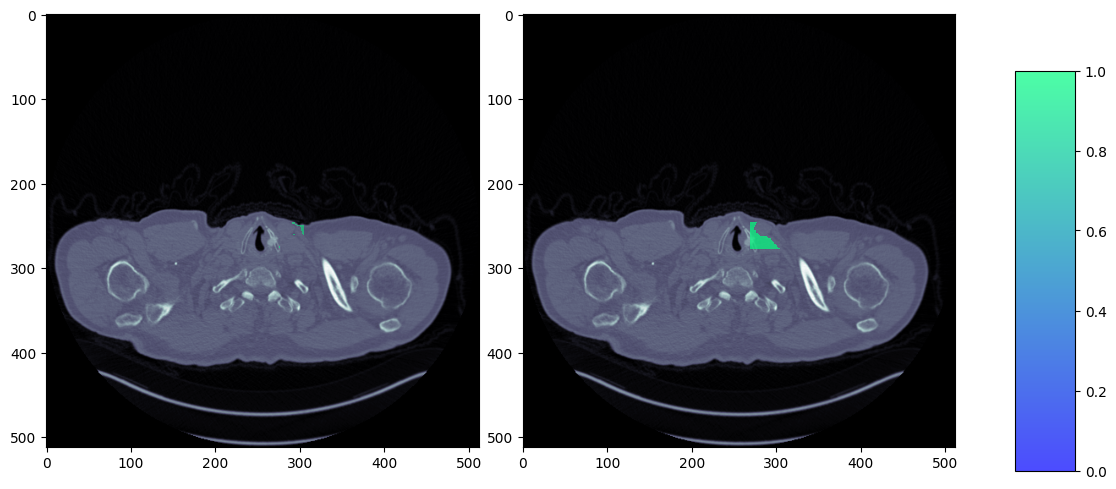

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))


nppred = result_levels[0]

#slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
#slice_ = int(0.5*slice_)
#slice_ = np.argmax(nppred.sum(axis=(0,1)))
slice_ = np.argmax(lab.sum(axis=(0,1))) - 4
#slice_ = np.where(lab > 0)[2].min() + 5
#slice_ = np.where(lab > 0)[2].max() - 55

ax[0].imshow(ct_img[:,:,slice_].T, cmap='bone')
ax[0].imshow(np.ma.masked_where(lab[:,:,slice_].T < 0.5, lab[:,:,slice_].T), cmap='winter', alpha=0.5, vmin=0., vmax=1., interpolation='none')

ax[1].imshow(ct_img[:,:,slice_].T, cmap='bone')
im = ax[1].imshow(np.ma.masked_where(nppred[:,:,slice_].T < 0.5, nppred[:,:,slice_].T), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [19]:
%matplotlib inline

## Tests

In [115]:
level = 'level_iii_left'
myspecs = level_specs[level]

In [116]:
myspecs

{'inferior border': [{'border': ['inferior border'],
   'structure': 'cricoid_cartilage'}],
 'superior border': [{'border': ['inferior border'], 'structure': 'hyoid'}],
 'posterior border': [{'border': ['posterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'anterior border': [{'border': ['anterior border'],
   'structure': 'sternocleidomastoid_left'}],
 'left border': [{'border': ['left border'],
   'structure': 'sternocleidomastoid_left'}],
 'right border': [{'border': ['right border'],
   'structure': 'common_carotid_artery_left'}]}

In [11]:
seg_file_path = os.path.join(
                        path_to_totalseg_segmentations,
                        totalseg_structure_to_task['sternocleidomastoid_left.nii.gz'],
                        patient,
                        'sternocleidomastoid_left.nii.gz'
                    )
seg_file_path

'/mnt/nas/database_CAL_immuno_lucie/pet_metrics_project/runs/cal_cancer_patients/seg_and_metrics_run_2024_04_09/output/SEG/headneck_muscles/0000002_20171205/sternocleidomastoid_left.nii.gz'

In [12]:
organ_segmentation = nib.load(seg_file_path).get_fdata()

In [25]:

specs_to_args = {
    'inferior border': {'axis': 2, 'get_largest_index': False,  'one_after': True},
    'superior border': {'axis': 2, 'get_largest_index': True,  'one_after': False},
    'anterior border': {'axis': 1, 'get_largest_index': False,  'one_after': True},
    'posterior border': {'axis': 1, 'get_largest_index': True,  'one_after': False},
    'left border': {'axis': 0, 'get_largest_index': True,  'one_after': False},
    'right border': {'axis': 0, 'get_largest_index': False,  'one_after': True},
}

In [80]:
border = 'left border'
one_after = specs_to_args[border]['one_after']
axis = specs_to_args[border]['axis']
organ_border_name = myspecs[border][0]['border'][0]
get_largest_index = specs_to_args[organ_border_name]['get_largest_index']

In [81]:
organ_segmentation = np.array(
                      [[0,0,1,1,0,0],
                      [0,0,0,1,1,0],
                      [0,0,0,0,1,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]])
organ_segmentation = organ_segmentation[:,:,None]

In [99]:
indices = [[],[],[]]
w = np.array(np.where(organ_segmentation > 0))
other_ax = [0,1,2]
_ = other_ax.pop(axis)
ax1 = other_ax[-1]
ax2 = other_ax[0]
for ax1_idx in np.unique(w[ax1,:]):
    for ax2_idx in np.unique(w[ax2,w[ax1,:] == ax1_idx]):
        axis_idx = np.max(w[axis,(w[ax1,:] == ax1_idx)&(w[ax2,:] == ax2_idx)]) if get_largest_index else np.min(w[axis,(w[ax1,:] == ax1_idx)&(w[ax2,:] == ax2_idx)])
        indices[ax1].append(int(ax1_idx))
        indices[ax2].append(int(ax2_idx))
        indices[axis].append(int(axis_idx))
        print(ax1_idx, ax2_idx, axis_idx)

0 2 0
0 3 1
0 4 2
0 5 3


In [100]:
area_mask = np.zeros_like(organ_segmentation)
for i in range(len(indices[0])):
    selecting_slice = [slice(None),slice(None),slice(None)]
    selecting_slice[ax1] = indices[ax1][i]
    selecting_slice[ax2] = indices[ax2][i]
    selecting_slice[axis] = slice(indices[axis][i], None) if one_after else slice(None, indices[axis][i])
    print(selecting_slice)
    area_mask[*selecting_slice] = 1

[slice(None, 0, None), 2, 0]
[slice(None, 1, None), 3, 0]
[slice(None, 2, None), 4, 0]
[slice(None, 3, None), 5, 0]


In [101]:
organ_segmentation[...,0]

array([[0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [102]:
area_mask[...,0]

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])